## Importações

In [94]:
%matplotlib inline

import sys
import lumapi
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.constants import c
import utils

In [95]:
inter = lumapi.INTERCONNECT()

In [96]:
um = 1e-6
nm = 1e-9

delta_L = [572.91631966,  57.29163197,  28.64581598]

Com o uso de Y-Branch na entrada e saída do MZI, não é possível obter, em uma única simulação, transmissões defasadas (assim como observado em MZI com saída utilizando acoplador direcional). Para isso, é somada uma parcela $x$ ao $\Delta L$, onde:

$$x = \frac{\lambda}{2n_{eff}}$$

In [97]:
lamb = 1560.25*nm
neff = 2.353696366632936
ngroup = 4.242296678553947

FSR = np.array([1*nm,5.5*nm,20*nm])

delta_L = (lamb**2)/(ngroup*FSR)

x_transmissao_defasada = lamb/(2*neff)
print(x_transmissao_defasada*1e6)
print(delta_L*1e6)

0.3314467452384279
[573.83541203 104.33371128  28.6917706 ]


## Criação e posicionamento dos blocos

In [98]:

inter.switchtodesign()
inter.deleteall()

inter.addelement('Optical Network Analyzer')
inter.set("number of points",1000)
inter.set("number of input ports",2)
inter.set("input parameter",2)
inter.set("start frequency", c/(1500*nm))
inter.set("stop frequency", c/(1600*nm))

guia_menor = 50*um

# 1 - ideal
# 2 - simulado
# 3 - pdk
caso = 3
#delta_L[0] 1um
#delta_L[1] 10um
#delta_L[2] 20um

indice = 1
delta_L = delta_L[indice]


inter.expressioncheckoff()
inter.addelement("ebeam_bdc_te1550")
inter.set("name", "Y1")

inter.select("Y1")
inter.copy()
inter.set("name","Y2")
inter.rotateelement("Y2")
inter.rotateelement("Y2")

inter.addelement('ebeam_wg_integral_1550')
inter.set("name", "Guia_1")
inter.set("annotate", False)
inter.set("wg_length", guia_menor + delta_L )
inter.set("wg_width", 500e-9)

inter.addelement('ebeam_wg_integral_1550')
inter.set("name", "Guia_2")
inter.set("annotate", False)
inter.set("wg_length", guia_menor)
inter.set("wg_width", 500e-9)

inter.setposition("ONA_1",0,0)
inter.setposition("Y1",-200,250)
inter.setposition("Y2",200,250)
inter.setposition("Guia_1",0,175)
inter.setposition("Guia_2",0,325)


## Conexão dos blocos

In [99]:

inter.connect("Y1", "opt_3", "Guia_1", "port 1")
inter.connect("Y1", "opt_4", "Guia_2", "port 1")
inter.connect("Guia_1", "port 2", "Y2", "opt_4")
inter.connect("Guia_2", "port 2", "Y2", "opt_3")
inter.connect("ONA_1", "output", "Y1", "opt_1")
inter.connect("ONA_1", "input 1", "Y2", "opt_1")    
inter.connect("ONA_1", "input 2", "Y2", "opt_2")    


1.0

In [100]:
inter.run()

## Obtenção de resultados

In [101]:
if (caso == 1):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['TE gain (dB)'])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["TE free spectral range (m)"]

elif (caso == 2):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['mode 1 gain (dB)'])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["mode 1 free spectral range (m)"]
    
elif (caso == 3):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")["TE gain (dB)"])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["TE free spectral range (m)"]
    
    TE_gain2 = np.squeeze(inter.getresult("ONA_1","input 2/mode 1/gain")["TE gain (dB)"])
    FSR2 = inter.getresult("ONA_1","input 2/mode 1/peak/free spectral range")
    fsr_wv2= np.squeeze(FSR2['wavelength'])
    FSR2 = FSR2["TE free spectral range (m)"]
    

comprimentos_de_onda = np.squeeze(inter.getresult("ONA_1","input 2/mode 1/gain")['wavelength'])

In [102]:
print(FSR1)

[5.79422632e-09 5.75222811e-09 5.71068487e-09 5.66959005e-09
 5.52695319e-09 5.58944746e-09 5.54965204e-09 5.51028012e-09
 5.47132569e-09 5.43278289e-09 5.39464594e-09 5.35690914e-09
 5.31956694e-09 5.28261384e-09 5.24604445e-09 5.11544970e-09
 5.11544970e-09]


<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\4247761219.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L*1e6:.3f} $\mu$")
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\4247761219.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L*1e6:.3f} $\mu$")
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\4247761219.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt

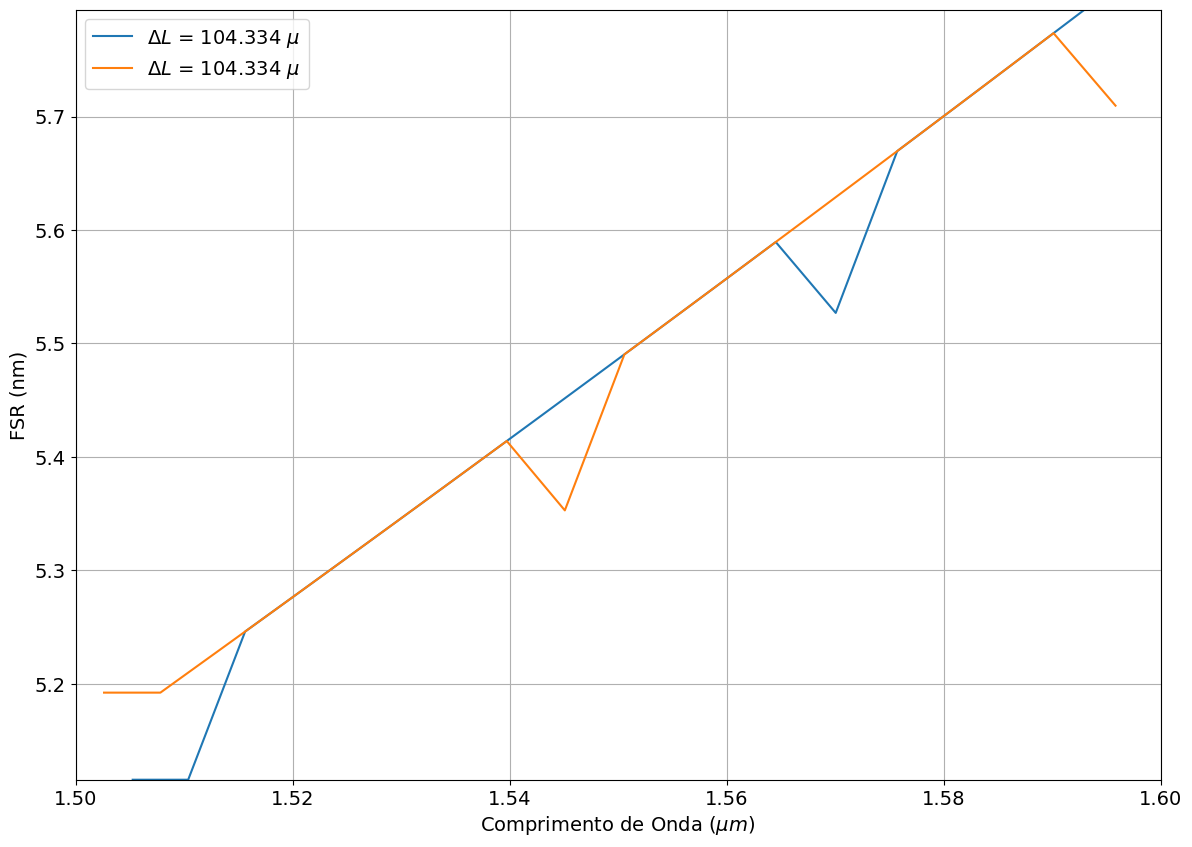

In [103]:
plt.figure(figsize=(14,10))

plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L*1e6:.3f} $\mu$")
plt.plot(fsr_wv2*1e6,FSR2*1e9, label = f"$\Delta L$ = {delta_L*1e6:.3f} $\mu$")
plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)
plt.ylabel('FSR (nm)', fontsize = 14)

plt.tick_params(axis='both', labelsize=14)

plt.xlim(1.5,1.6)
plt.ylim(min(FSR1*1e9) ,max(FSR1*1e9))

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)

plt.savefig(f'FSR {FSR[indice]*1e9:.2f} PDK.png')
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\3709493304.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(comprimentos_de_onda*1e6,TE_gain, label = f"FSR = {FSR[indice]*1e9:.2f} nm, L = {(guia_menor + delta_L*um)*1e6:.3f} $\mu$")
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\3709493304.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(comprimentos_de_onda*1e6,TE_gain2, label = f'FSR = {FSR[indice]*1e9:.2f} nm, L = {(guia_menor + delta_L*um +x_transmissao_defasada)*1e6:.3f} $\mu$')
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\3709493304.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)


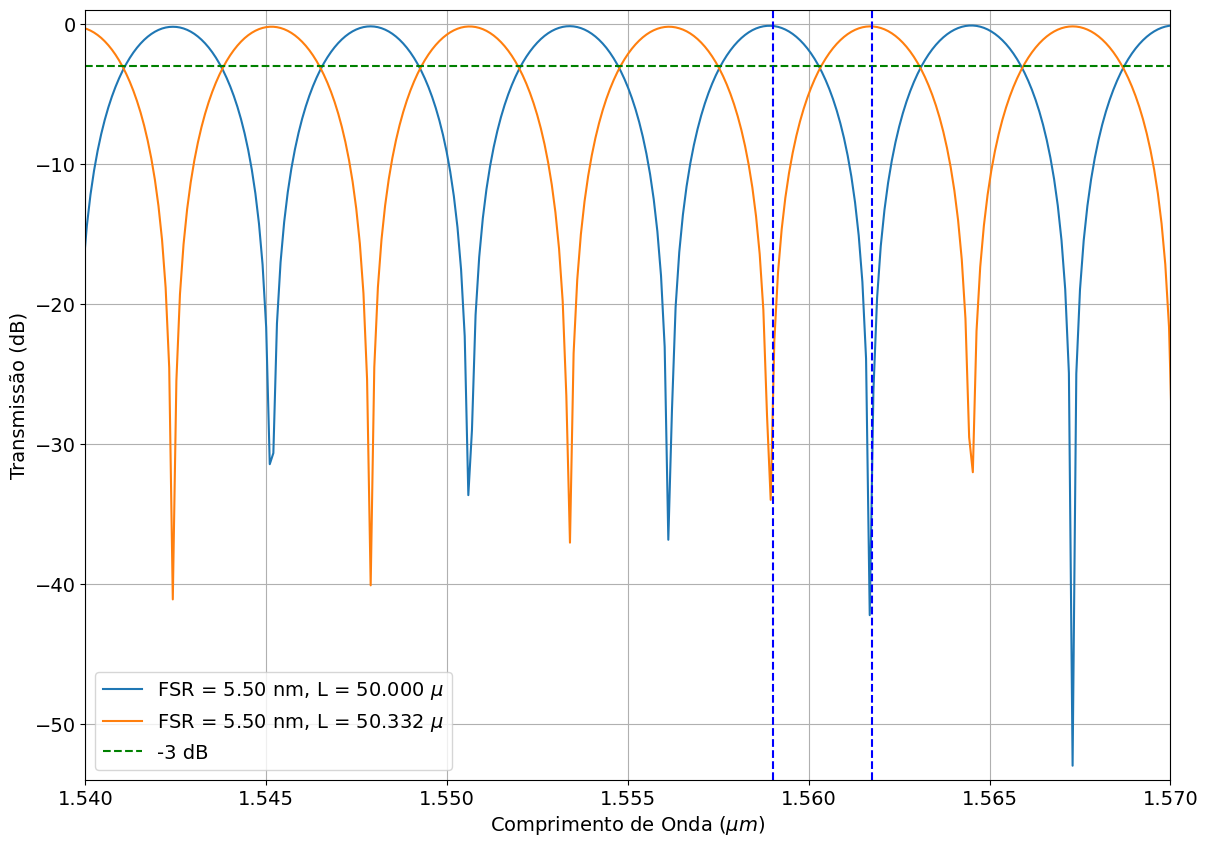

In [104]:

plt.figure(figsize=(14,10))

plt.plot(comprimentos_de_onda*1e6,TE_gain, label = f"FSR = {FSR[indice]*1e9:.2f} nm, L = {(guia_menor + delta_L*um)*1e6:.3f} $\mu$")
plt.plot(comprimentos_de_onda*1e6,TE_gain2, label = f'FSR = {FSR[indice]*1e9:.2f} nm, L = {(guia_menor + delta_L*um +x_transmissao_defasada)*1e6:.3f} $\mu$')
plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)
plt.ylabel('Transmissão (dB)', fontsize = 14)

plt.axhline(y=-3, linestyle='--', color ="g",label = '-3 dB')
plt.axvline(x=1.559, linestyle='--', color ="b")
plt.axvline(x=1.56175, linestyle='--', color ="b")
plt.tick_params(axis='both', labelsize=14)

plt.xlim(1.540,1.570)
plt.ylim(min(TE_gain) - 1 ,1)

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)

plt.savefig(f'GANHO IDEAL FSR {FSR[indice]*1e9:.2f}nm E DEFASADO.png')
plt.show()


In [105]:
##inter.close()

In [106]:

def funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_1,defasagem,diretorio_dos_parametros_S):
        # funcao cria ambiente de simulacao no INTERCONNECT composto por dois laser, um combiner, um dispositivo arbitrario (a depender do parametro S),
        #  um splitter, dois filtros, dois fotodectores e dois medidores de potencia. Posteriormente simula e retorna os valores de potencia lidos nos medidores de potencia.

        # inter - referente a funcao da API lumapi. inter = lumapi.INTERCONNECT().
        # x_1 - float - comprimento de onda do laser 1.
        # defasagem - float - comprimento de onda defasado de x_1. a soma defasagem+x_1 eh o comprimento de onda do laser 2.
        # diretorio_dos_parametros_S - string - diretorio com o nome do arquivo com parametro S .dat

        inter.switchtolayout()
        inter.deleteall()
 
        inter.addelement('Optical Network Analyzer')
        inter.set("number of points",1000)
        inter.set("number of input ports",2)
        inter.set("input parameter",2)
        inter.set("start frequency", c/(1500*nm))
        inter.set("stop frequency", c/(1600*nm))

        # inter.addelement("CW Laser")
        # inter.set("name", "fonte2")
        # inter.set("frequency", 3e8/(x_1+defasagem))

        # inter.addelement("CW Laser")
        # inter.set("name", "fonte1")
        # inter.set("frequency", 3e8/((x_1)))

        # inter.addelement("Optical Combiner")
        # inter.set("name", "optC1")

        inter.addelement("Optical N Port S-Parameter")
        inter.set("name","spars1")
        inter.set("load from file", True)
        inter.set("s parameters filename", diretorio_dos_parametros_S)


        inter.expressioncheckoff()
        inter.addelement("ebeam_bdc_te1550")
        inter.set("name", "Y1")

        inter.select("Y1")
        inter.copy()
        inter.set("name","Y2")
        inter.rotateelement("Y2")
        inter.rotateelement("Y2")

        inter.addelement('ebeam_wg_integral_1550')
        inter.set("name", "Guia_1")
        inter.set("annotate", False)
        inter.set("wg_length", guia_menor + delta_L )
        inter.set("wg_width", 500e-9)

        inter.addelement('ebeam_wg_integral_1550')
        inter.set("name", "Guia_2")
        inter.set("annotate", False)
        inter.set("wg_length", guia_menor)
        inter.set("wg_width", 500e-9)

        # inter.setposition("fonte1", 0,0)
        # inter.setposition("fonte2", 0,200)

        # inter.setposition("optC1", 200,100)
        inter.setposition("spars1", 400,100)

        inter.setposition("Y1",600,100)

        inter.setposition("Guia_1",800,0)
        inter.setposition("Guia_2",800,200)
        inter.setposition("Y2",1000,100)

        inter.setposition("ONA_1",600,-200)

        # inter.connect("fonte2", "output", "optC1", "input 2")
        # inter.connect("fonte1", "output", "optC1", "input 1")

        # inter.connect("optC1", "output", "spars1", "port 1")
        inter.connect("ONA_1", "output", "spars1", "port 1")

        inter.connect("spars1","port 2", "Y1", "opt_2")
        inter.connect("Y1","opt_3", "Guia_1", "port 1")
        inter.connect("Y1","opt_4", "Guia_2", "port 1")
        inter.connect("Guia_1", "port 2", "Y2", "opt_4")
        inter.connect("Guia_2", "port 2", "Y2", "opt_3")

        inter.connect("Y2","opt_1", "ONA_1", "input 2")
        inter.connect("Y2","opt_2", "ONA_1", "input 1")
        
        return 0


In [109]:
x1 = 1.559
x1_defasado = x1+2.75
caminho = fr"C:\Users\gson5\Downloads\Photonics-API-lumapi\MZI FOR SILICON BRAGG\BRAGG STRAIN PHASE SHIFTER\bragg_strain_1.dat"

funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x1,x1_defasado,caminho)
inter.run()

In [110]:
TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")["TE gain (dB)"])
FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
fsr_wv= np.squeeze(FSR1['wavelength'])
FSR1 = FSR1["TE free spectral range (m)"]

TE_gain2 = np.squeeze(inter.getresult("ONA_1","input 2/mode 1/gain")["TE gain (dB)"])
FSR2 = inter.getresult("ONA_1","input 2/mode 1/peak/free spectral range")
fsr_wv2= np.squeeze(FSR2['wavelength'])
FSR2 = FSR2["TE free spectral range (m)"]


comprimentos_de_onda = np.squeeze(inter.getresult("ONA_1","input 2/mode 1/gain")['wavelength'])

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\3709493304.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(comprimentos_de_onda*1e6,TE_gain, label = f"FSR = {FSR[indice]*1e9:.2f} nm, L = {(guia_menor + delta_L*um)*1e6:.3f} $\mu$")
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\3709493304.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(comprimentos_de_onda*1e6,TE_gain2, label = f'FSR = {FSR[indice]*1e9:.2f} nm, L = {(guia_menor + delta_L*um +x_transmissao_defasada)*1e6:.3f} $\mu$')
C:\Users\gson5\AppData\Local\Temp\ipykernel_51172\3709493304.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)


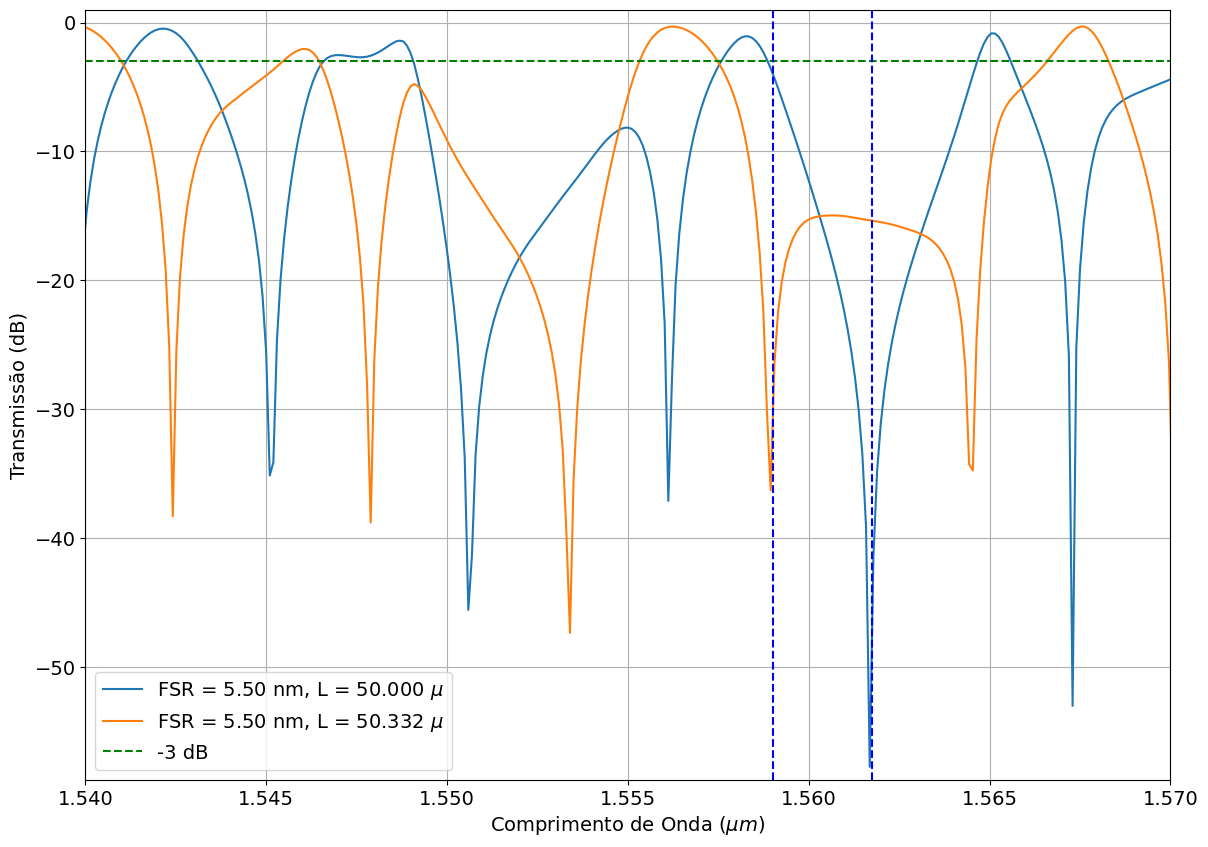

In [ ]:

plt.figure(figsize=(14,10))

plt.plot(comprimentos_de_onda*1e6,TE_gain, label = f"FSR = {FSR[indice]*1e9:.2f} nm, L = {(guia_menor + delta_L*um)*1e6:.3f} $\mu$")
plt.plot(comprimentos_de_onda*1e6,TE_gain2, label = f'FSR = {FSR[indice]*1e9:.2f} nm, L = {(guia_menor + delta_L*um +x_transmissao_defasada)*1e6:.3f} $\mu$')
plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)
plt.ylabel('Transmissão (dB)', fontsize = 14)

plt.axhline(y=-3, linestyle='--', color ="g",label = '-3 dB')
plt.axvline(x=1.559, linestyle='--', color ="b")
plt.axvline(x=1.56175, linestyle='--', color ="b")
plt.tick_params(axis='both', labelsize=14)

plt.xlim(1.540,1.570)
plt.ylim(min(TE_gain) - 1 ,1)

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)

plt.savefig(f'GANHO IDEAL FSR {FSR[indice]*1e9:.2f}nm E DEFASADO PARA BRAGG.png')
plt.show()
